In [1]:
##############################
#Chris OWID JDS exercise     #
#Maintainer: Christopher Chan#
#Version: 0.0.2              #
#Date: 2023-02-26            #
##############################

import os, sys, re
import statsmodels
import pathlib

import numpy as np
import pandas as pd
import openpyxl as opx
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

data_raw = pathlib.Path('../data/01_raw/')
data_intermediate = pathlib.Path('../data/02_intermediate/')
data_output = pathlib.Path('../data/07_model_output/')

## GOAL: Calculate both Crude Death Rate and Age-Standardised Death Rate from Age-Specific Death Rates
### Data:
1. UN WPP Population Estiamtes (1950-2021) (UN DESA., 2022)
2. WHO Standard Population Distribution aggregate (Ahmad et al., 2001)
3. Age-Specific Death Rates COPD 2019

### Definitions (ONS., 2023):
> Age-Specific Death Rates: Number of deaths in hte age group per 1,000 population in the same age group\
> Crude Death Rate: Total deaths per 1,000 population\
> Age-Standardised Death Rates: 

In [9]:
# Data ingest
# pandas 2.0

# Loop ingestion of various WPP pop estimate variants
WPP = {}
with pd.ExcelFile(f"{data_raw}/WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_REV1.xlsx") as WPP_wb:
    for i in WPP_wb.sheet_names:
        if i != 'NOTES':
            st_name = i.replace(' ', '_')
            WPP[st_name] = pd.read_excel(f"{data_raw}/WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_REV1.xlsx",
                                         sheet_name = i, skiprows = np.arange(0, 16, 1).tolist())

assert WPP["Estimates"].columns.tolist() == WPP["Instant-replacement_zero_migr"].columns.tolist(), "Columns names do not match!"

# Other datasets
with open(f"{data_raw}/WHO_ASR.csv") as WHO_df:
    WHO_SPD = pd.read_csv(WHO_df, delimiter = ',')
with open(f"{data_raw}/age_specific_COPD.csv") as AS_df:
    AS_COPD = pd.read_csv(AS_df, delimiter = ',')

In [10]:
WPP["High_variant"][WPP["High_variant"]["Year"] == 2022]

,Index,Variant,"Region, subregion, country or area *",Notes,Location code,ISO3 Alpha-code,ISO2 Alpha-code,SDMX code**,Type,Parent code,...,"Male Mortality before Age 60 (deaths under age 60 per 1,000 male live births)","Female Mortality before Age 60 (deaths under age 60 per 1,000 female live births)","Mortality between Age 15 and 50, both sexes (deaths under age 50 per 1,000 alive at age 15)","Male Mortality between Age 15 and 50 (deaths under age 50 per 1,000 males alive at age 15)","Female Mortality between Age 15 and 50 (deaths under age 50 per 1,000 females alive at age 15)","Mortality between Age 15 and 60, both sexes (deaths under age 60 per 1,000 alive at age 15)","Male Mortality between Age 15 and 60 (deaths under age 60 per 1,000 males alive at age 15)","Female Mortality between Age 15 and 60 (deaths under age 60 per 1,000 females alive at age 15)",Net Number of Migrants (thousands),"Net Migration Rate (per 1,000 population)"
0,1,High,WORLD,NaN,900,NaN,NaN,1.0,World,0,...,224.064,155.558,78.931,95.683,61.297,152.967,185.961,118.483,0,0
80,81,High,Sub-Saharan Africa,b,1834,NaN,NaN,202.0,SDG region,1828,...,400.475,328.908,175.682,195.913,155.235,300.363,335.962,264.788,-450.072,-0.385
159,160,High,Northern Africa and Western Asia,NaN,1833,NaN,NaN,747.0,SDG region,1828,...,177.432,114.587,53.64,66.058,39.699,122.67,150.803,91.157,40.909,0.074
238,239,High,Central and Southern Asia,NaN,1831,NaN,NaN,62.0,SDG region,1828,...,260.507,191.657,87.143,104.97,68.233,194.173,227.863,158.2,-1270.348,-0.608
317,318,High,Eastern and South-Eastern Asia,NaN,1832,NaN,NaN,753.0,SDG region,1828,...,144.132,85.666,47.193,58.903,34.676,100.039,127.284,71.487,-322.943,-0.138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22203,22204,High,Samoa,NaN,882,WSM,WS,882.0,Country/Area,957,...,191.932,124.525,62.983,76.674,48.685,141.627,172.458,107.452,-1.5,-6.711
22282,22283,High,Tokelau,35,772,TKL,TK,772.0,Country/Area,957,...,138.518,137.223,61.563,57.267,65.838,129.968,130.622,130.308,0,0
22361,22362,High,Tonga,NaN,776,TON,TO,776.0,Country/Area,957,...,240.088,162.637,93.789,111.406,77.66,189.669,227.862,151.131,-0.8,-7.446
22440,22441,High,Tuvalu,NaN,798,TUV,TV,798.0,Country/Area,957,...,393.821,230.433,166.314,209.391,115.979,302.188,374.681,209.364,-0.06,-5.28


In [12]:
WPP["High_variant"].dtypes

Index                                                                                              int64
Variant                                                                                           object
Region, subregion, country or area *                                                              object
Notes                                                                                             object
Location code                                                                                      int64
                                                                                                   ...  
Mortality between Age 15 and 60, both sexes (deaths under age 60 per 1,000 alive at age 15)       object
Male Mortality between Age 15 and 60 (deaths under age 60 per 1,000 males alive at age 15)        object
Female Mortality between Age 15 and 60 (deaths under age 60 per 1,000 females alive at age 15)    object
Net Number of Migrants (thousands)                     

### Calculate Crude Death Rate for USA and Uganda 2019

> CDR = (Total deaths / Total pop) * 1000

Since there are no 2019 data for the UN WPP population estimate, I will use cubic spline to interpolate the 2019 figures

In [45]:
# Single sample test for USA
USAtest_df = WPP["High_variant"][(WPP["High_variant"]["ISO3 Alpha-code"] == "USA") & WPP["High_variant"]["Year"].isin([2022, 2023, 2024, 2025, 2026])]
USAtest_df = USAtest_df[["Year", "Total Deaths (thousands)", "Total Population, as of 1 July (thousands)"]]
USAtest_df["Crude Death Rate"] = USAtest_df["Total Deaths (thousands)"]/USAtest_df["Total Population, as of 1 July (thousands)"]
print(USAtest_df)

         Year Total Deaths (thousands)  \
20307  2022.0                 3147.089   
20308  2023.0                 2915.292   
20309  2024.0                 2958.059   
20310  2025.0                 3003.291   
20311  2026.0                 3049.624   

      Total Population, as of 1 July (thousands) Crude Death Rate  
20307                                 338569.083         0.009295  
20308                                 340835.182         0.008553  
20309                                 343214.419         0.008619  
20310                                 345566.857         0.008691  
20311                                 347893.856         0.008766  


In [46]:
# Single sample test for UGA
UGAtest_df = WPP["High_variant"][(WPP["High_variant"]["ISO3 Alpha-code"] == "UGA") & WPP["High_variant"]["Year"].isin([2022, 2023, 2024, 2025, 2026])]
UGAtest_df = UGAtest_df[["Year", "Total Deaths (thousands)", "Total Population, as of 1 July (thousands)"]]
UGAtest_df["Crude Death Rate"] = UGAtest_df["Total Deaths (thousands)"]/UGAtest_df["Total Population, as of 1 July (thousands)"]
print(UGAtest_df)

        Year Total Deaths (thousands)  \
3164  2022.0                  266.476   
3165  2023.0                  271.272   
3166  2024.0                  275.641   
3167  2025.0                  280.309   
3168  2026.0                  285.095   

     Total Population, as of 1 July (thousands) Crude Death Rate  
3164                                  47296.291         0.005634  
3165                                  48723.799         0.005568  
3166                                  50163.315         0.005495  
3167                                  51624.405          0.00543  
3168                                   53111.42         0.005368  


> Test examples do suggest that USA have much higher CDR than Uganda, let's see if this is true when interpolated for 2019 and the real data?

In [47]:
def UNWPP_interp_CDR(df_dict, target_year):

    df = pd.DataFrame({"Country": np.tile(["USA", "UGA"], len(df_dict.keys())),
                       "Variant_estimate": np.repeat(list(df_dict.keys()), 2),
                       "CDR": np.nan})

    cdr_values = []

    for k in df_dict.keys():
        print(f"Calculation variant {k}")
        USA = df_dict[k][df_dict[k]["ISO3 Alpha-code"] == "USA"]
        UGA = df_dict[k][df_dict[k]["ISO3 Alpha-code"] == "UGA"]

        print(USA[["ISO3 Alpha-code", "Total Deaths (thousands)", "Total Population, as of 1 July (thousands)"]])
        print(UGA[["ISO3 Alpha-code", "Total Deaths (thousands)", "Total Population, as of 1 July (thousands)"]])

        # USA cubic spline
        USA_vTD_cs = sp.interpolate.CubicSpline(USA["Year"], USA["Total Deaths (thousands)"])
        USA_vTD = USA_vTD_cs(target_year)
        USA_vTP_cs = sp.interpolate.CubicSpline(USA["Year"], USA["Total Population, as of 1 July (thousands)"])
        USA_vTP = USA_vTP_cs(target_year)
        USA_vCDR = USA_vTD / USA_vTP

        # UGA cubic spline
        UGA_vTD_cs = sp.interpolate.CubicSpline(UGA["Year"], UGA["Total Deaths (thousands)"])
        UGA_vTD = UGA_vTD_cs(target_year)
        UGA_vTP_cs = sp.interpolate.CubicSpline(UGA["Year"], UGA["Total Population, as of 1 July (thousands)"])
        UGA_vTP = UGA_vTP_cs(target_year)
        UGA_vCDR = UGA_vTD / UGA_vTP

        print(f"For year {target_year}, USA {k} Crude Death Rate is {USA_vCDR} and UGA {k} Crude Death Rate is {UGA_vCDR}")

        #vCDR = [USA_vCDR, UGA_vCDR]

        cdr_values.append([USA_vCDR, UGA_vCDR])

    df["CDR"] = np.concatenate(cdr_values)
        
    return df

interpDF_2019 = UNWPP_interp_CDR(WPP, 2019)
print(interpDF_2019)

Calculation variant Estimates
      ISO3 Alpha-code Total Deaths (thousands)  \
18508             USA                 1427.489   
18509             USA                 1458.412   
18510             USA                 1472.732   
18511             USA                 1488.696   
18512             USA                 1452.153   
...               ...                      ...   
18575             USA                 2772.099   
18576             USA                 2780.175   
18577             USA                 2778.148   
18578             USA                 3238.518   
18579             USA                 3280.682   

      Total Population, as of 1 July (thousands)  
18508                                  148281.55  
18509                                 150598.453  
18510                                 152941.727  
18511                                 155451.199  
18512                                 158205.873  
...                                          ...  
18575       

### Calculate Crude Death Rate from COPD data (per 100,000)

In [48]:
ASpec_COPD["Death rate, United States, 2019 (per 1,000)"] = ASpec_COPD["Death rate, United States, 2019"] / 100
ASpec_COPD["Death rate, Uganda, 2019 (per 1,000)"] = ASpec_COPD["Death rate, Uganda, 2019"] / 100

# Population data not interpreted but sourced from census
#https://www.census.gov/newsroom/press-releases/2019/popest-nation.html USA
#https://www.ubos.org/wp-content/uploads/statistics/Census_Population_counts_(2002_and_2014)_by_Region,_District_and_Mid-Year_Population_projections_(2015-2021).xlsx Uganda
CDRreal_USA = np.sum(ASpec_COPD["Death rate, United States, 2019 (per 1,000)"])/328239.523
CDRreal_UGA = np.sum(ASpec_COPD["Death rate, Uganda, 2019 (per 1,000)"])/ 8647.400

print(f"Real Crude Death Rate (2019) for United States is {CDRreal_USA}, and for Uganda is {CDRreal_UGA}")

Real Crude Death Rate (2019) for United States is 6.595001053544669e-05, and for Uganda is 0.0023806230774568076


In [49]:
# Plotting interpolated against real CDR
realUSA_df = pd.DataFrame({"Country": ["USA"], "Variant_estimate": ["Real"], "CDR": [CDRreal_USA]})
realUGA_df = pd.DataFrame({"Country": ["UGA"], "Variant_estimate": ["Real"], "CDR": [CDRreal_UGA]})

interpDF_2019 = pd.concat([interpDF_2019, realUSA_df, realUGA_df]).reset_index(drop = True)
print(interpDF_2019.tail())

interpDF_2019.to_csv(f'{data_output}/vCDR_2019.csv', sep = ',')

   Country    Variant_estimate       CDR
19     UGA  Constant-mortality  0.005445
20     USA           No_change  0.008695
21     UGA           No_change  0.005501
22     USA                Real  0.000066
23     UGA                Real  0.002381


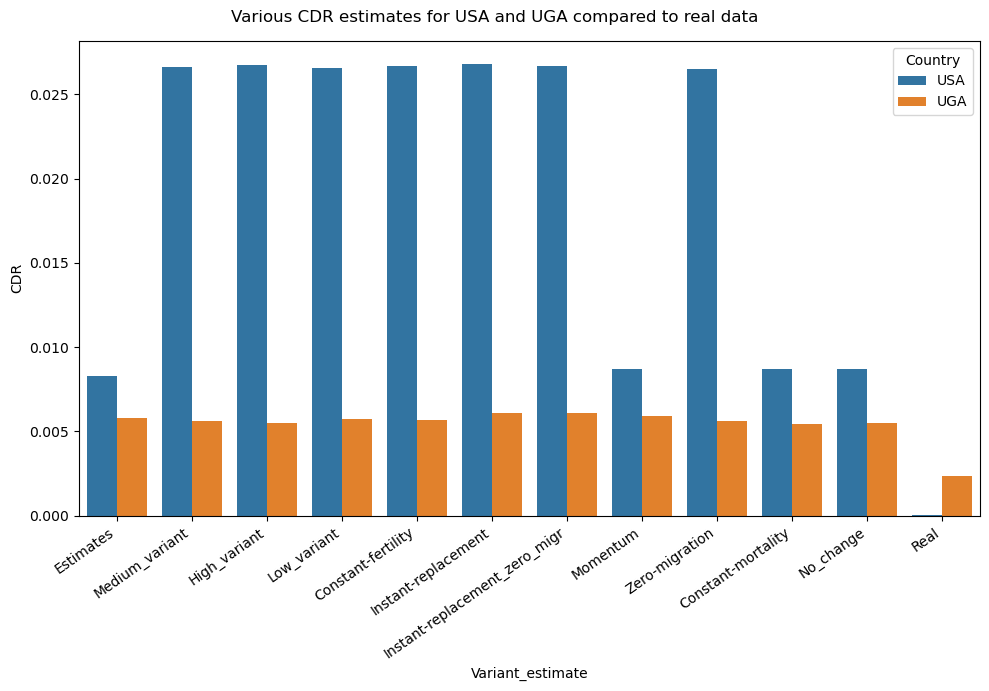

In [51]:
# Plotting
fig, ax = plt.subplots(figsize = (10, 7))

sns.barplot(data = interpDF_2019,
            x = "Variant_estimate", y = "CDR",
            hue = "Country")

plt.suptitle("Various CDR estimates for USA and UGA compared to real data")
plt.xticks(rotation = 35, ha = "right")

fig.tight_layout()
plt.savefig("../docs/CDR_barplot.png")
plt.show()

Interpolation for 2019 do track small testing sample where USA CDR > UGA CDR, the interpolation do make sensing, and the real data is significantly flipped. But overall statistics projection for both country overestimate death!

### Calculate Age-Standardised Death Rate from Age-Specific Death Rate (per 100,000) for USA and Uganda 2019

> ASDR = 

In [16]:
ASpec_COPD

,Age group (years),"Death rate, United States, 2019","Death rate, Uganda, 2019"
0,0-4,0.04,0.4
1,5-9,0.02,0.17
2,10-14,0.02,0.07
3,15-19,0.02,0.23
4,20-24,0.06,0.38
5,25-29,0.11,0.4
6,30-34,0.29,0.75
7,35-39,0.56,1.11
8,40-44,1.42,2.04
9,45-49,4.0,5.51
